Load toolboxes:

In [ ]:
import helper
import plot_settings

# import packages
import pymaid
import navis
import pickle
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, kstest, lognorm, gamma, mannwhitneyu

path_plots = 'plots/'

# Set matplotlib style
plt.rcParams.update(plot_settings.params)

### Load the required data from the server:

In [2]:
# load the remote instance of pymaid to the server
l1em = pymaid.connect_catmaid(server="https://l1em.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False)    # L1 Larval CNS
l3vnc = pymaid.connect_catmaid(server="https://l3vnc.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False, project_id=2)  # L3 Larval VNC

neurons_str = 'Gerhard et al. 2017'

# load neurons
# l1_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l1em)
l1_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l1em)
l1_neurons.set_neuron_attributes(neurons_str, 'annotation')
# l3_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons.set_neuron_attributes(neurons_str, 'annotation')

# replace ' ' in all the names with '_' to match the names in the database
for neuron in l1_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])
for neuron in l3_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])

# filter out neurons without 'a1' or 'a3' in the name
for neuron in l1_neurons:
    if 'a1' not in neuron.name:
        l1_neurons -= neuron
for neuron in l3_neurons:
    if 'a3' not in neuron.name:
        l3_neurons -= neuron

INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)
INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)


Fetch neurons:   0%|          | 0/55 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/55 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/18 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/18 [00:00<?, ?it/s]

Organise the neuron cell types:

In [3]:
# Get mdIV (ddaC, v'ada and vdaB) neurons in L1 and L3
l1_ddaC_neurons = helper.filter_neurons(l1_neurons, 'ddaC')
l1_vada_neurons = helper.filter_neurons(l1_neurons, 'v\'ada')
l1_vdaB_neurons = helper.filter_neurons(l1_neurons, 'vdaB')
l3_ddaC_neurons = helper.filter_neurons(l3_neurons, 'ddaC')
l3_vada_neurons = helper.filter_neurons(l3_neurons, 'v\'ada')
l3_vdaB_neurons = helper.filter_neurons(l3_neurons, 'vdaB')

l1_mdIV_neurons = l1_ddaC_neurons + l1_vada_neurons + l1_vdaB_neurons
l3_mdIV_neurons = l3_ddaC_neurons + l3_vada_neurons + l3_vdaB_neurons

# Get LNs (A02n, A09a, A09c, A09l, A10a) neurons in L1 and L3
l1_A02n_neurons = helper.filter_neurons(l1_neurons, 'A02n')
l1_A02m_neurons = helper.filter_neurons(l1_neurons, 'A02m')
l1_A09a_neurons = helper.filter_neurons(l1_neurons, 'A09a')
l1_A09c_neurons = helper.filter_neurons(l1_neurons, 'A09c')
l1_A09l_neurons = helper.filter_neurons(l1_neurons, 'A09l')
l1_A10a_neurons = helper.filter_neurons(l1_neurons, 'A10a')

l3_A02n_neurons = helper.filter_neurons(l3_neurons, 'A02n')
l3_A02m_neurons = helper.filter_neurons(l3_neurons, 'A02m')
l3_A09a_neurons = helper.filter_neurons(l3_neurons, 'A09a')
l3_A09c_neurons = helper.filter_neurons(l3_neurons, 'A09c')
l3_A09l_neurons = helper.filter_neurons(l3_neurons, 'A09l')
l3_A10a_neurons = helper.filter_neurons(l3_neurons, 'A10a')

l1_LN_neurons = l1_A02n_neurons + l1_A02m_neurons + l1_A09a_neurons + l1_A09c_neurons + l1_A09l_neurons + l1_A10a_neurons
l3_LN_neurons = l3_A02n_neurons + l3_A02m_neurons + l3_A09a_neurons + l3_A09c_neurons + l3_A09l_neurons + l3_A10a_neurons

# sort all the neurons by name (left to right)
for neuron in [l1_ddaC_neurons, l1_vada_neurons, l1_vdaB_neurons, l3_ddaC_neurons, l3_vada_neurons, l3_vdaB_neurons,    # mdIVs
                l1_A02n_neurons, l1_A09a_neurons, l1_A09c_neurons, l1_A09l_neurons, l1_A10a_neurons, l3_A02n_neurons, l3_A09a_neurons, l3_A09c_neurons, l3_A09l_neurons, l3_A10a_neurons, # LNs
                l1_mdIV_neurons, l3_mdIV_neurons, l1_LN_neurons, l3_LN_neurons,
                ]:
    neuron.sort_values(key='name', ascending=True)

# create color dictionary for the neurons
for source_name in l1_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l1_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]
# create color dictionary for the neurons
for source_name in l3_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l3_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]

In [4]:
###########################################################
# Actual synapses
# l1_connectors = pymaid.get_connectors_between(l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
l1_connectors = helper.try_with_retries(pymaid.get_connectors_between, 5, l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
# l3_connectors = pymaid.get_connectors_between(l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)
l3_connectors = helper.try_with_retries(pymaid.get_connectors_between, 5, l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)

# add name tags of source and target neurons
l1_connectors['source_name'] = [l1_mdIV_neurons[l1_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l1_connectors.source_neuron]
l1_connectors['target_name'] = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0] for id in l1_connectors.target_neuron]
l3_connectors['source_name'] = [l3_mdIV_neurons[l3_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l3_connectors.source_neuron]
l3_connectors['target_name'] = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0] for id in l3_connectors.target_neuron]

Load quantified PSD areas:

In [5]:
# load the areas dataframe
with open('l1_PSD_areas.pkl', 'rb') as f:
    l1_PSD_areas = pickle.load(f)

# load the areas dataframe
with open('l3_PSD_areas.pkl', 'rb') as f:
    l3_PSD_areas = pickle.load(f)

l3_PSD_areas

,pre_skeleton_id,pre_treenode_id,connector_id,post_treenode_id,post_skeleton_id,area,node2_id
0,189519,20187,20189,20209,1591487,7218.498551,20230
0,189519,20187,20189,20230,406883,65542.067786,20216
0,189519,20187,20189,20216,1771441,19115.920626,20209
0,1591477,22366,22368,22352,1591487,42049.376593,22352
0,1870224,25546,25548,25554,1725730,32317.223638,25554
...,...,...,...,...,...,...,...
0,1591468,379255,1942071,1662763,1591495,11644.305910,1662763
0,1591468,432794,1942332,1063836,1591495,6876.883835,1063836
0,1591477,1477508,1944587,1944584,1771441,40699.263325,1944584
0,1591472,206467,1945278,1945276,1771441,19401.727984,1945276


In [6]:
l1_connectors['area'] = [
    l1_PSD_areas[(l1_PSD_areas.connector_id == c_id) & (l1_PSD_areas.node2_id == n2_id)]['area'].values[0]
    for c_id, n2_id in l1_connectors[['connector_id', 'node2_id']].values
]
l3_connectors['area'] = [
    l3_PSD_areas[(l3_PSD_areas.connector_id == c_id) & (l3_PSD_areas.node2_id == n2_id)]['area'].values[0]
    for c_id, n2_id in l3_connectors[['connector_id', 'node2_id']].values
]

l3_connectors

,connector_id,connector_loc,node1_id,source_neuron,confidence1,creator1,node1_loc,node2_id,target_neuron,confidence2,creator2,node2_loc,source_name,target_name,area
0,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20209,1591487,5,NaN,"[71605.9, 59714.9, 71500.0]",ddaC_a3l,A09l_a3r,19115.920626
1,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20216,1771441,5,NaN,"[71688.7, 59781.6, 71450.0]",ddaC_a3l,A09a_a3r,65542.067786
2,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20230,406883,5,NaN,"[71916.4, 59786.2, 71250.0]",ddaC_a3l,A02m_a3l,7218.498551
3,406621,"[58783.4, 59645.9, 61500.0]",406620,189519,5,NaN,"[58630.4, 59873.6, 61500.0]",406627,1078668,5,NaN,"[58817.9, 59567.7, 61500.0]",ddaC_a3l,A02n_a3l,23400.226535
4,406814,"[59077.8, 59609.1, 69100.0]",406813,189519,5,NaN,"[59095.1, 59728.7, 69100.0]",406820,1584165,5,NaN,"[58928.3, 59567.7, 69100.0]",ddaC_a3l,A10a_a3r,7869.036790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,1930834,"[61212.2, 58696.0, 71250.0]",1021586,1870224,5,NaN,"[61260.1, 59050.2, 71250.0]",1862720,1725730,5,NaN,"[61384.7, 58581.0, 71250.0]",vdaB_a3r,A09c_a3l,36710.339803
1558,1931020,"[69549.7, 58371.7, 75200.0]",1022088,1870224,5,NaN,"[69488.8, 58548.8, 75150.0]",1425060,1725730,5,NaN,"[69556.6, 58245.2, 75200.0]",vdaB_a3r,A09c_a3l,38264.532445
1559,1940337,"[59805.8, 61659.7, 70250.0]",1390529,1870224,5,NaN,"[60141.9, 61857.7, 70250.0]",1133937,1725730,5,NaN,"[59636.7, 61545.7, 70250.0]",vdaB_a3r,A09c_a3l,52764.107474
1560,1940337,"[59805.8, 61659.7, 70250.0]",1390529,1870224,5,NaN,"[60141.9, 61857.7, 70250.0]",537233,1584165,5,NaN,"[59924.2, 61459.4, 70250.0]",vdaB_a3r,A10a_a3r,16815.920626


In [7]:
l1_median_area = (l1_PSD_areas['area']/100_000).median()
l3_median_area = (l3_PSD_areas['area']/100_000).median()
l3_median_area / l1_median_area

0.8057202938985757

## Figure 2

### Figure 2 panel B:

p-value (before scaling): 1.8227298645948537e-05
p-value (after scaling by 0.8057202938985756): 0.6669958352756998


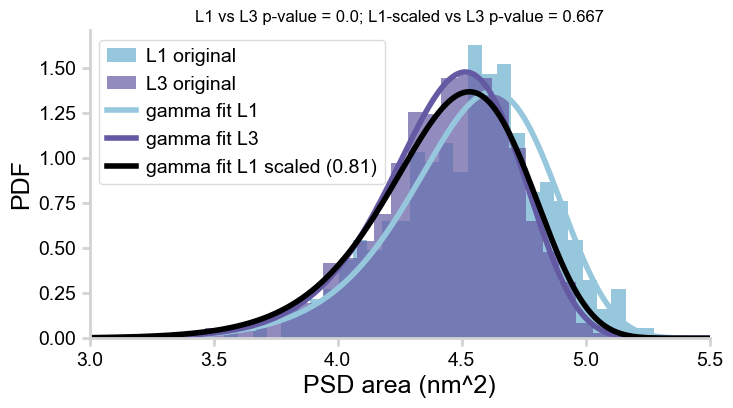

In [8]:
# Now perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(l1_PSD_areas['area'], l3_PSD_areas['area'])
print(f"p-value (before scaling): {p_value}")

# Rescale l1_PSD_areas by a scalar and repeat the test
l1_median_area = (l1_PSD_areas['area']).median()
l3_median_area = (l3_PSD_areas['area']).median()
scaling_factor = l3_median_area / l1_median_area # Adjust this scalar to fit distributions
l1_scaled = l1_PSD_areas['area'] * scaling_factor

# Perform the KS test after rescaling
ks_statistic_scaled, p_value_scaled = ks_2samp(l1_scaled, l3_PSD_areas['area'])
print(f"p-value (after scaling by {scaling_factor}): {p_value_scaled}")
   
# Fit gamma distribution to the scaled data
params_scaled = gamma.fit(l1_scaled, floc=0)
params1 = gamma.fit(l1_PSD_areas['area'], floc=0)
params2 = gamma.fit(l3_PSD_areas['area'], floc=0)

# Generate PDF values for the fitted distributions
# x = np.linspace(min(np.log10(l1_PSD_areas['area'])), max(np.log10(l1_PSD_areas['area'])), 1000)
x = np.linspace(min(l1_PSD_areas['area']), max(l1_PSD_areas['area']), 1000)
x_log = np.linspace(3, 5.5, 1000)
x_lin = 10 ** x_log

pdf_scaled = gamma.pdf(x_lin, *params_scaled) * np.log(10) * x_lin
pdf1 = gamma.pdf(x_lin, *params1) * np.log(10) * x_lin
pdf2 = gamma.pdf(x_lin, *params2) * np.log(10) * x_lin

# Plot the histograms with the scaling applied
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

# Original data
np.log10(l1_PSD_areas['area']).plot.hist(bins=30, ax=ax1, density=True, alpha=1, color=plot_settings.l1_color, label='L1 original')
np.log10(l3_PSD_areas['area']).plot.hist(bins=30, ax=ax1, density=True, alpha=0.7, color=plot_settings.l3_color, label='L3 original')
# Plot fitted distributions
pd.DataFrame({'gamma fit L1': pdf1}, index=x_log).plot.line(color=plot_settings.l1_color, lw=4, ax=ax1)
pd.DataFrame({'gamma fit L3': pdf2}, index=x_log).plot.line(color=plot_settings.l3_color, lw=4, ax=ax1)
# Scaled data
pd.DataFrame({f'gamma fit L1 scaled ({scaling_factor:.2f})': pdf_scaled}, index=x_log).plot.line(color='k', lw=4, ax=ax1)

# Set labels and legends
ax1.set_xlabel('PSD area (nm^2)')
ax1.set_ylabel('PDF')
ax1.set_title(f'L1 vs L3 p-value = {round(p_value, 4)}; L1-scaled vs L3 p-value = {round(p_value_scaled, 4)}')
ax1.set_xlim((3, 5.5))
ax1.legend()

# plt.savefig(path_plots+'Fig2/'+'Fig2B.png')
# plt.savefig(path_plots+'Fig2/'+'Fig2B.svg')

### Figure 2 panel C:

/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_18075/2620923769.py:22: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(data=combined_data, x='target_name', y='area', hue='layer',


Text(0, 0.5, 'Area')

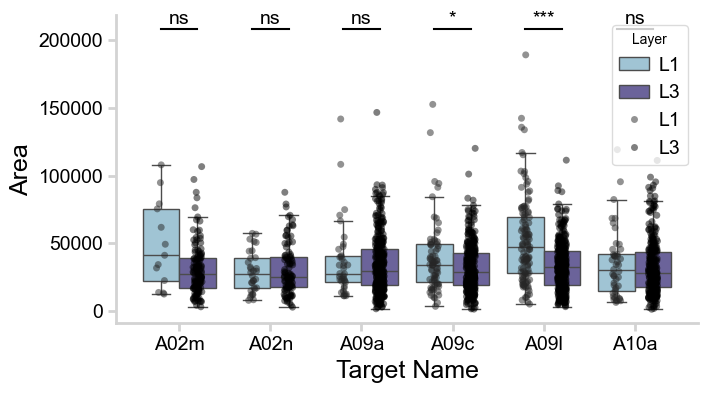

In [9]:
# Copy and label each dataset
l1_data = l1_connectors.copy()
l3_data = l3_connectors.copy()
l1_data['target_name'] = [c.split('_')[0] for c in l1_data['target_name']]
l3_data['target_name'] = [c.split('_')[0] for c in l3_data['target_name']]
l1_data['source_name'] = [c.split('_')[0] for c in l1_data['source_name']]
l3_data['source_name'] = [c.split('_')[0] for c in l3_data['source_name']]
# Sort by target_name
l1_data.sort_values(by='target_name', inplace=True)
l3_data.sort_values(by='target_name', inplace=True)

# Add a label to each dataset for easy distinction in the plot
l1_data['layer'] = 'L1'
l3_data['layer'] = 'L3'

# Concatenate the data for a combined plot
combined_data = pd.concat([l1_data, l3_data])

plt.figure(figsize=(7.5, 4))

sns.boxplot(data=combined_data, x='target_name', y='area', hue='layer',palette=plot_settings.color_dict,fliersize=0)
sns.stripplot(data=combined_data, x='target_name', y='area', hue='layer',
                dodge=True,
                marker='o',
                size=5,
                color='k',
                alpha=0.5,
              )

# Loop over each target group to perform statistical tests and add significance lines
target_groups = combined_data['target_name'].unique()

for i, target in enumerate(target_groups):
    l1_values = combined_data[(combined_data['target_name'] == target) & (combined_data['layer'] == 'L1')]['area']
    l3_values = combined_data[(combined_data['target_name'] == target) & (combined_data['layer'] == 'L3')]['area']
    
    # Perform Mann-Whitney U test
    if not l1_values.empty and not l3_values.empty:
        stat, p_value = mannwhitneyu(l1_values, l3_values, alternative='two-sided')
        # Add significance line and label
        y, h, col = combined_data['area'].max(), combined_data['area'].max()/200, 'k'  # line height and color
        plt.plot([i - 0.2, i + 0.2], [y*1.1, y*1.1], lw=1.5, color=col)  # line above violins
        # Add significance text above line
        plt.text(i, y*1.1 + h, helper.get_significance_star(p_value), ha='center', va='bottom', color=col, fontsize=14)
        
plt.legend(title='Layer')
plt.xlabel("Target Name")
plt.ylabel("Area")

# plt.savefig(path_plots+'Fig2/'+'Fig2C.png')
# plt.savefig(path_plots+'Fig2/'+'Fig2C.svg')

## Supplementary Figure 2 S1

### Supp. Figure 2 S1 panel AB:

Log-normal KS test: statistic=0.05491951572799647, p-value=0.2806926686949204
Gamma KS test: statistic=0.042919257204947825, p-value=0.5841632784504664
Log-normal KS test: statistic=0.05349994480340825, p-value=0.00025136064537380437
Gamma KS test: statistic=0.013870749464856558, p-value=0.9204432834771438


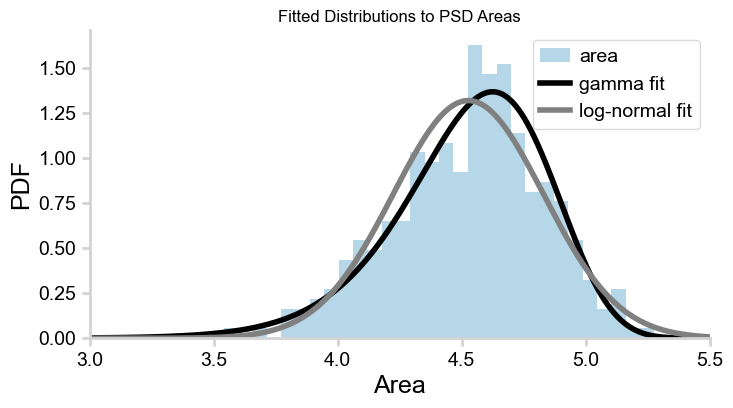

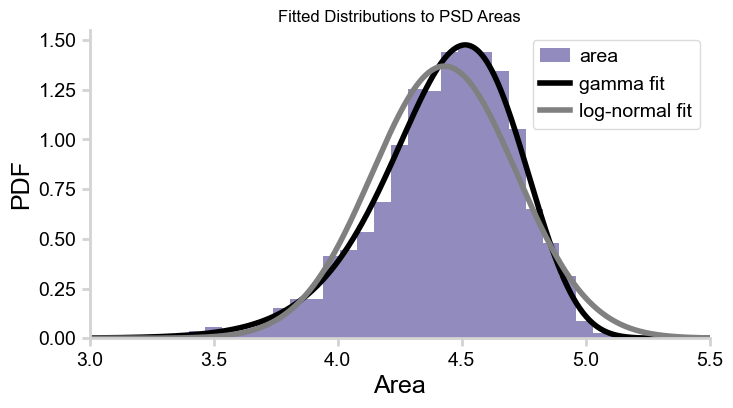

In [10]:
datasets = [l1_PSD_areas['area'], l3_PSD_areas['area']]

colors = [plot_settings.l1_color, plot_settings.l3_color]

for i, data in enumerate(datasets):
    # Fit log-normal (scipy's lognorm uses shape=s, loc, scale)
    params_ln = lognorm.fit(data, floc=0)
    # Fit gamma
    params_gamma = gamma.fit(data, floc=0)
    # # Fit Weibull
    # shape_w, loc_w, scale_w = weibull_min.fit(data, floc=0)

    # Compare data to the fitted log-normal distribution
    ks_lognorm = kstest(data, 'lognorm', args=(params_ln[0], params_ln[1], params_ln[2]))
    # Compare to gamma
    ks_gamma = kstest(data, 'gamma', args=(params_gamma[0], params_gamma[1], params_gamma[2]))
    # # Compare to Weibull
    # ks_weibull = kstest(data, 'weibull_min', args=(shape_w, loc_w, scale_w))

    print(f'Log-normal KS test: statistic={ks_lognorm.statistic}, p-value={ks_lognorm.pvalue}')
    print(f'Gamma KS test: statistic={ks_gamma.statistic}, p-value={ks_gamma.pvalue}')
    # print(f'Weibull KS test: statistic={ks_weibull.statistic}, p-value={ks_weibull.pvalue}')

    # Plot the data and the fits
    # x_lin = np.logspace(data.min(), data.max(), 1000)  # Also log-spaced for smooth PDF curves
    # x_log = np.logspace(np.log10(data.min()), np.log10(data.max()), 1000)
    x_log = np.linspace(3, 5.5, 1000)
    x_lin = 10 ** x_log
    
    pdf_gamma = gamma.pdf(x_lin, *params_gamma) * np.log(10) * x_lin
    pdf_lognorm = lognorm.pdf(x_lin, *params_ln) * np.log(10) * x_lin

    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    
    np.log10(data).plot.hist(bins=30, density=True, alpha=0.7, color=colors[i], ax=ax1)
    # Plot fits
    pd.DataFrame({'gamma fit': pdf_gamma}, index=x_log).plot.line(color='k', lw=4, ax=ax1)
    pd.DataFrame({'log-normal fit': pdf_lognorm}, index=x_log).plot.line(color='gray', lw=4, ax=ax1)

    # Axes and legend
    ax1.set_xlabel('Area')
    ax1.set_ylabel('PDF')
    ax1.set_title('Fitted Distributions to PSD Areas')
    ax1.set_xlim((3, 5.5))
    ax1.legend()

    # if i == 0:
    #     plt.savefig(path_plots+'Fig2/'+'Fig2S1A.png')
    #     plt.savefig(path_plots+'Fig2/'+'Fig2S1A.svg')
    # else:
    #     plt.savefig(path_plots+'Fig2/'+'Fig2S1B.png')
    #     plt.savefig(path_plots+'Fig2/'+'Fig2S1B.svg')